# Diagnosing Heart Disease
## Using ML Explainability Tools and Techniques

<img style="float: left;" src="https://guardian.ng/wp-content/uploads/2016/08/Heart-diseases.jpg" width="350px"/>

# Contents

1. [Introduction ](#section1)
2. [The Data](#section2)
3. [The Model](#section3)
4. [The Explanation](#section4)
5. [Conclusion](#section5)

<a id='section1'></a>

# Introduction

Of all the applications of machine-learning, diagnosing any serious disease using a black box is always going to be a hard sell. If the output from a model is the particular course of treatment (potentially with side-effects), or surgery, or the *absence* of treatment, people are going to want to know **why**.

This dataset gives a number of variables along with a target condition of having or not having heart disease. Below, the data is first used in a simple random forest model, and then the model is investigated using ML explainability tools and techniques.

Learn more in Dan Becker's course in Kaggle Learn [here](https://www.kaggle.com/learn/machine-learning-explainability)

First, load the appropriate libraries,

In [1]:
#!pip install eli5 shap pdpbox
#MARCIO DE LIMA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

/home/marcio/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/marcio/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='la

<a id='section2'></a>

# The Data

Next, load the data,

In [20]:
dt = pd.read_csv("../dados/heart.csv")

Let's take a look,

In [4]:
dt.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,

- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more [here](https://litfl.com/st-segment-ecg-library/))
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)

To avoid [HARKing](https://journals.sagepub.com/doi/abs/10.1207/s15327957pspr0203_4) (or Hypothesizing After the Results are Known) I'm going to take a look at online guides on how heart disease is diagnosed, and look up some of the terms above.

**Diagnosis**: The diagnosis of heart disease is done on a combination of clinical signs and test results. The types of tests run will be chosen on the basis of what the physician thinks is going on [1](https://www.mayoclinic.org/diseases-conditions/heart-disease/diagnosis-treatment/drc-20353124), ranging from electrocardiograms and cardiac computerized tomography (CT) scans, to blood tests and exercise stress tests [2](https://www.heartfoundation.org.au/your-heart/living-with-heart-disease/medical-tests).

Looking at information of heart disease risk factors led me to the following: **high cholesterol, high blood pressure, diabetes, weight, family history and smoking** [3](https://www.bhf.org.uk/informationsupport/risk-factors). According to another source [4](https://www.heart.org/en/health-topics/heart-attack/understand-your-risks-to-prevent-a-heart-attack), the major factors that can't be changed are: **increasing age, male gender and heredity**. Note that **thalassemia**, one of the variables in this dataset, is heredity. Major factors that can be modified are: **Smoking, high cholesterol, high blood pressure, physical inactivity, and being overweight and having diabetes**. Other factors include **stress, alcohol and poor diet/nutrition**.

I can see no reference to the 'number of major vessels', but given that the definition of heart disease is **"...what happens when your heart's blood supply is blocked or interrupted by a build-up of fatty substances in the coronary arteries"**, it seems logical the *more* major vessels is a good thing, and therefore will reduce the probability of heart disease.

Given the above, I would hypothesis that, if the model has some predictive ability, we'll see these factors standing out as the most important.

Let's change the column names to be a bit clearer,

In [21]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

I'm also going to change the values of the categorical variables, to improve the interpretation later on,

In [6]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

Check the data types,

In [19]:
dt.dtypes

age                                          int64
resting_blood_pressure                       int64
cholesterol                                  int64
max_heart_rate_achieved                      int64
st_depression                              float64
num_major_vessels                            int64
target                                       int64
sex_male                                     uint8
chest_pain_type_atypical angina              uint8
chest_pain_type_non-anginal pain             uint8
chest_pain_type_typical angina               uint8
fasting_blood_sugar_lower than 120mg/ml      uint8
rest_ecg_left ventricular hypertrophy        uint8
rest_ecg_normal                              uint8
exercise_induced_angina_yes                  uint8
st_slope_flat                                uint8
st_slope_upsloping                           uint8
thalassemia_fixed defect                     uint8
thalassemia_normal                           uint8
thalassemia_reversable defect  

Some of those aren't quite right. The code below changes them into categorical variables,

In [8]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [9]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

For the categorical varibles, we need to create dummy variables. I'm also going to drop the first category of each. For example, rather than having 'male' and 'female', we'll have 'male' with values of 0 or 1 (1 being male, and 0 therefore being female).

In [10]:
dt = pd.get_dummies(dt, drop_first=True)

Now let's see,

In [11]:
dt.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0


In [12]:
dt.columns

Index(['age', 'resting_blood_pressure', 'cholesterol',
       'max_heart_rate_achieved', 'st_depression', 'num_major_vessels',
       'target', 'sex_male', 'chest_pain_type_atypical angina',
       'chest_pain_type_non-anginal pain', 'chest_pain_type_typical angina',
       'fasting_blood_sugar_lower than 120mg/ml',
       'rest_ecg_left ventricular hypertrophy', 'rest_ecg_normal',
       'exercise_induced_angina_yes', 'st_slope_flat', 'st_slope_upsloping',
       'thalassemia_fixed defect', 'thalassemia_normal',
       'thalassemia_reversable defect'],
      dtype='object')

Looking good. Now, on to the model.

<a id='section3'></a>

# The Model

The next part fits a random forest model to the data,

In [12]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #split the data

In [13]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

We can plot the consequent decision tree, to see what it's doing,

In [14]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [15]:
#code from https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

This gives us on explainability tool. However, I can't glance at this and get a quick sense of the most important features. We'll revisit those later. Next, let's evaluate the model,

In [21]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)
y_pred_bin = model.predict(X_test)

Assess the fit with a confusion matrix,

In [16]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[28,  7],
       [ 3, 23]])

Diagnostic tests are often sold, marketed, cited and used with **sensitivity** and **specificity** as the headline metrics. Sensitivity and specificity are defined as,

\begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}

\begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}

Let's see what this model is giving,

In [18]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.9032258064516129
Specificity :  0.7666666666666667


That seems reasonable. Let's also check with a **[Receiver Operator Curve (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)**,

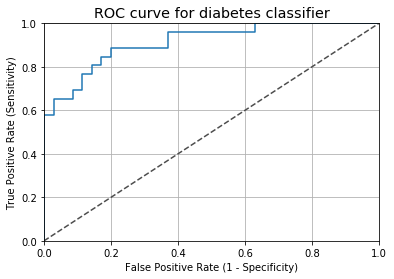

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Another common metric is the **Area Under the Curve**, or **AUC**. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail

Let's see what the above ROC gives us,

In [20]:
auc(fpr, tpr)

0.9131868131868132

OK, so it's working well.

<a id='section4'></a>

# The Explanation

Now let's see what the model gives us from the ML explainability tools.

**Permutation importance** is the first tool for understanding a machine-learning model, and involves shuffling individual variables in the validation data (after a model has been fit), and seeing the effect on accuracy. Learn more [here](https://www.kaggle.com/dansbecker/permutation-importance).

Let's take a look,


In [21]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0754 ± 0.0445,thalassemia_reversable defect
0.0459 ± 0.0321,max_heart_rate_achieved
0.0393 ± 0.0334,num_major_vessels
0.0295 ± 0.0245,st_depression
0.0197 ± 0.0382,thalassemia_fixed defect
0.0197 ± 0.0245,rest_ecg_normal
0.0164 ± 0.0000,exercise_induced_angina_yes
0.0131 ± 0.0131,sex_male
0.0131 ± 0.0131,cholesterol
0.0066 ± 0.0334,age


So, it looks like the most important factors in terms of permutation is a thalessemia result of 'reversable defect'. The high importance of 'max heart rate achieved' type makes sense, as this is the immediate, subjective state of the patient at the time of examination (as opposed to, say, age, which is a much more general factor).

Let's take a closer look at the number of major vessles using a **Partial Dependence Plot** (learn more [here](https://www.kaggle.com/dansbecker/partial-plots)). These plots vary a single variable in a single row across a range of values and see what effect it has on the outcome. It does this for several rows and plots the average effect. Let's take a look at the 'num_major_vessels' variable, which was at the top of the permutation importance list,

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


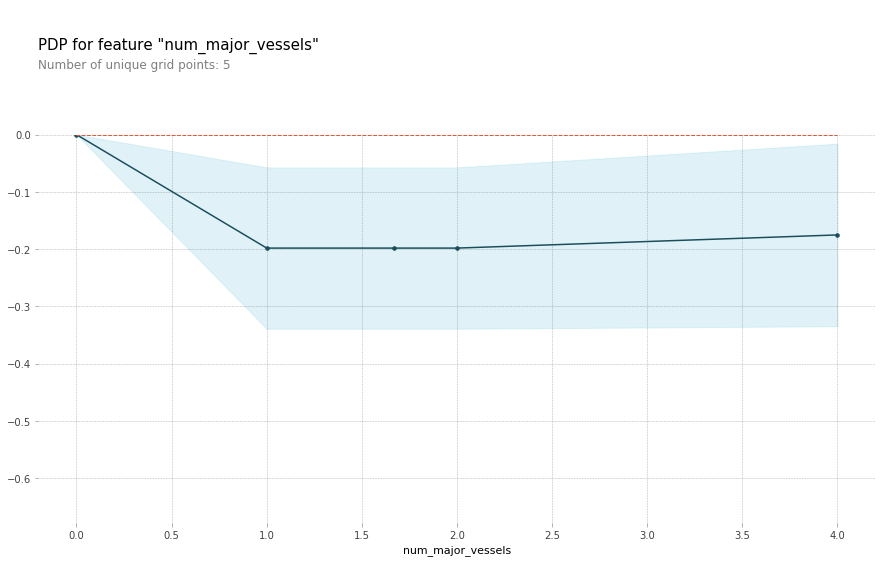

In [22]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

So, we can see that as the number of major blood vessels *increases*, the probability of heart disease *decreases*. That makes sense, as it means more blood can get to the heart.

What about the 'age',

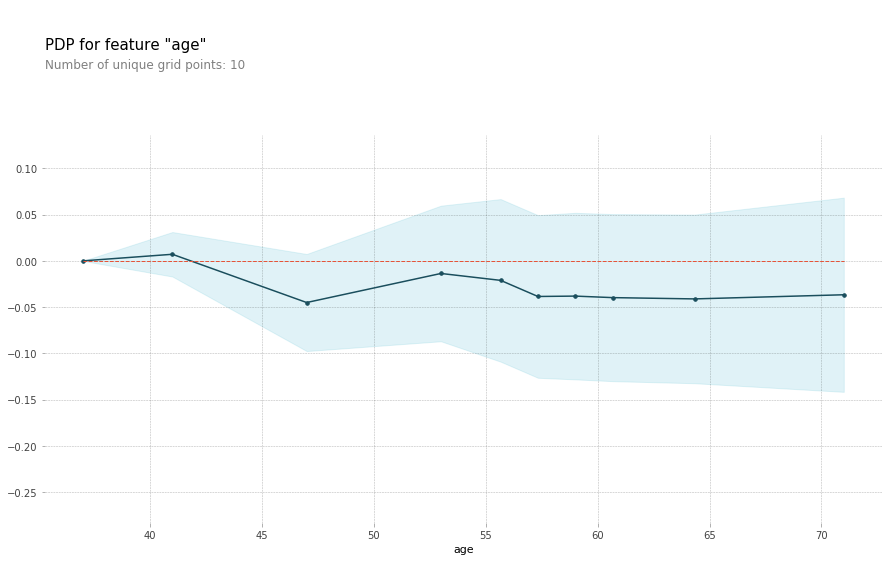

In [23]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

That's a bit odd. The higher the age, the lower the chance of heart disease? Althought the blue confidence regions show that this might not be true (the red baseline is within the blue zone).

What about the 'st_depression',

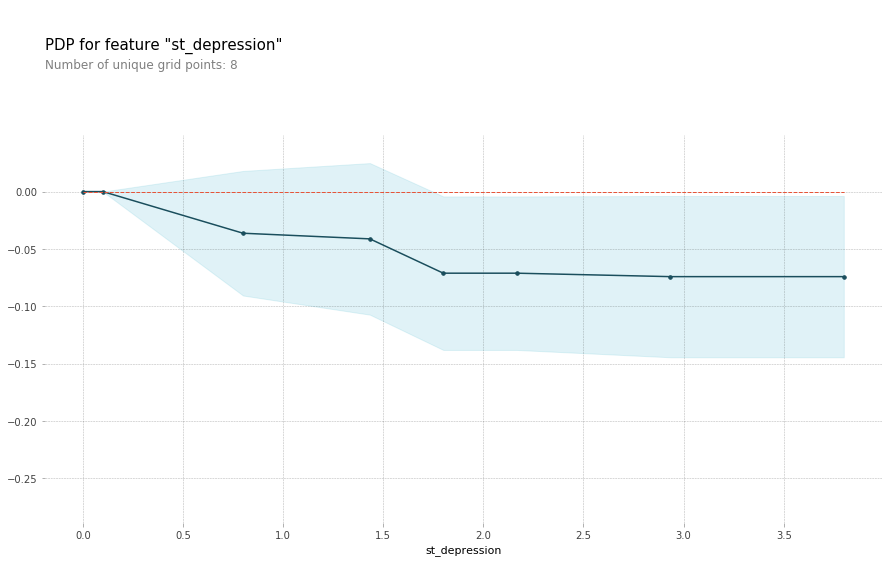

In [24]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Interestingly, this variable also shows a reduction in probability the higher it goes. What exactly is this? A search on Google brought me to the following description by Anthony L. Komaroff, MD, an internal medicine specialist [5](https://www.sharecare.com/health/circulatory-system-health/what-st-segment-electrocardiogram-ecg) .... *"An electrocardiogram (ECG) measures the heart's electrical activity. The waves that appear on it are labeled P, QRS, and T. Each corresponds to a different part of the heartbeat. The **ST segment** represents the heart's electrical activity immediately after the right and left ventricles have contracted, pumping blood to the lungs and the rest of the body. Following this big effort, ventricular muscle cells relax and get ready for the next contraction. During this period, little or no electricity is flowing, so the ST segment is even with the baseline or sometimes slightly above it. The faster the heart is beating during an ECG, the shorter all of the waves become. **The shape and direction of the ST segment are far more important than its length. Upward or downward shifts can represent decreased blood flow to the heart from a variety of causes, including heart attack, spasms in one or more coronary arteries (Prinzmetal's angina), infection of the lining of the heart (pericarditis) or the heart muscle itself (myocarditis), an excess of potassium in the bloodstream, a heart rhythm problem, or a blood clot in the lungs (pulmonary embolism)."***

<img style="float: left;" src="https://www.cvphysiology.com/uploads/images/CAD012%20ST%20elevation.png" width="350px"/>    [6](https://www.cvphysiology.com/CAD/CAD012)

So, this variable, which is described as 'ST depression induced by exercise relative to rest', seems to suggest the higher the value the higher the probability of heart disease, but the plot above shows the opposite. Perhaps it's not just the depression amount that's important, but the interaction with the slope type? Let's check with a 2D PDP,

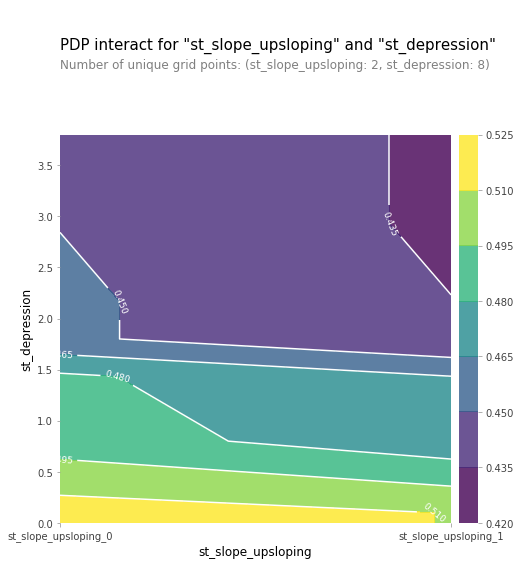

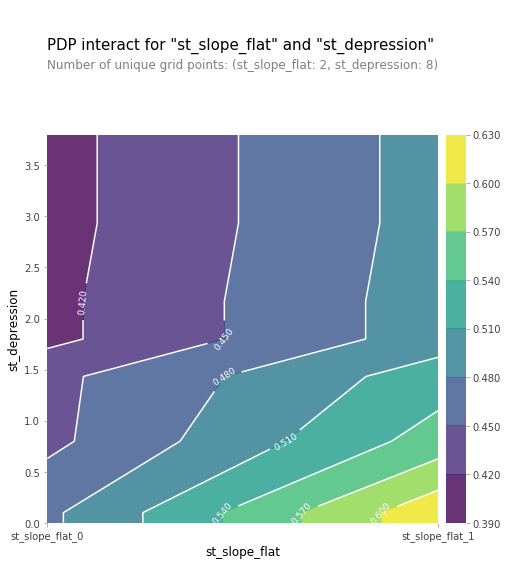

In [25]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], plot_type='contour')
plt.show()

inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_flat', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat', 'st_depression'], plot_type='contour')
plt.show()

It looks like a low depression is bad in both cases. Odd.

Let's see what the SHAP values tell us. These work by showing the influence of the values of every variable in a single row, compared to their baseline values (learn more [here](https://www.kaggle.com/dansbecker/shap-values)).

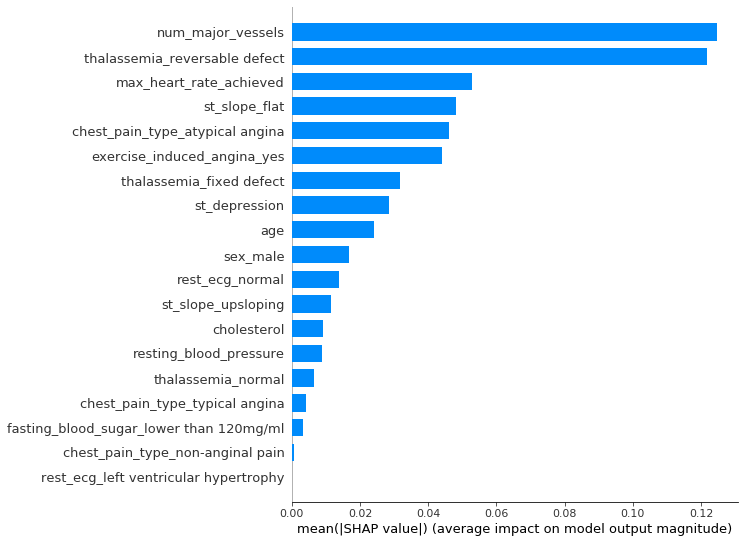

In [26]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

The number of major vessels is at the top. Let's use a summary plot of the SHAP values,

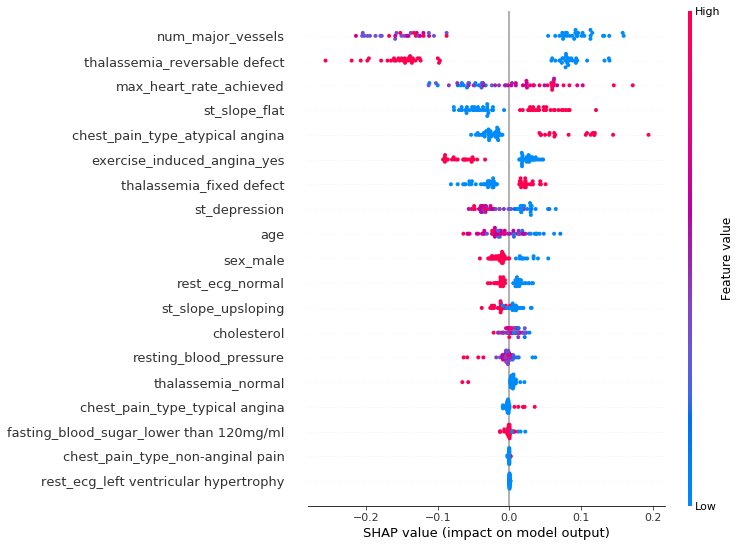

In [27]:
shap.summary_plot(shap_values[1], X_test)

The number of major vessels division is pretty clear, and it's saying that low values are bad (blue on the right). The thalassemia 'reversable defect' division is very clear (yes = red = good, no = blue = bad).

You can see some clear separation in many of the other variables. Exercise induced angina has a clear separation, although not as expected, as 'no' (blue) *increases* the probability. Another clear one is the st_slope. It looks like when it's flat, that's a bad sign (red on the right).

It's also odd is that the men (red) have a *reduced* chance of heart disease in this model. Why is this? Domain knowledge tells us that men have a greater chance.

Next, let's pick out individual patients and see how the different variables are affecting their outcomes,

In [28]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [29]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

For this person, their prediction is 36% (compared to a baseline of 58.4%). Many things are working in their favour, including having a major vessel, a reversible thalassemia defect, and *not* having a flat st_slope.

Let's check another,

In [30]:
data_for_prediction = X_test.iloc[3,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

For this person, their prediction is 70% (compared to a baseline of 58.4%). Not working in their favour are things like having no major vessels, a flat st_slope, and *not* a reversible thalassemia defect.

We can also plot something called 'SHAP dependence contribution plots' (learn more [here](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values)), which are pretty self-explanatory in the context of SHAP values,

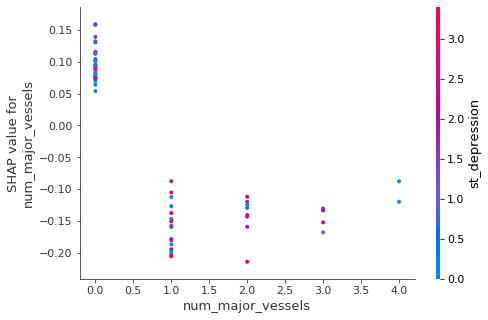

In [31]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('num_major_vessels', shap_values[1], X_test, interaction_index="st_depression")

You can see the stark effect on the number of major vessels, but there doesn't seem to be a lot to take from the colour (st_depression).

The final plot, for me, is one of the most effective. It shows the predictions and influencing factors for many (in this case 50) patients, all together. It's also interactive, which is great. Hover over to see *why* each person ended up either red (prediction of disease) or blue (prediction of no disease),

In [32]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

<a id='section5'></a>

# Conclusion

This dataset is old and small by today's standards. However, it's allowed us to create a simple model and then use various machine learning explainability tools and techniques to peek inside. At the start, I hypothesised, using (Googled) domain knowledge that factors such as cholesterol and age would be major factors in the model. This dataset didn't show that. Instead, the number of major factors and aspects of ECG results dominated. I actually feel like I've learnt a thing or two about heart disease!

I suspect this sort of approach will become increasingly important as machine learning has a greater and greater role in health care.

In [33]:
#Save Modelo - Marcio de Lima
import pickle

filename = 'modelo/original_model.pkl'
pickle.dump(model, open(filename, 'wb'))